In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md
import scTRS.method_121820 as md_old
import scTRS.method_simple as md_simple

# autoreload
%load_ext autoreload
%autoreload 2

### Load data 

In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
GENE_SCORE_PATH = join(DATA_PATH, 'trs_gene_scores')
hsapiens_mmusculus_mapping = pd.read_csv(join(GENE_SCORE_PATH, 'meta_data', 'hsapiens_mmusculus_mapping.csv'))

In [3]:
# Count data (used for scoring genes)
score_dataset = dl.load_tms_ct(DATA_PATH, data_name='facs')
score_dataset = score_dataset[0:20000]
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(score_dataset.shape[0], score_dataset.shape[1]))

Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=20000, n_gene=22966


In [4]:
### Get gene sets 
np.random.seed(0)
gene_set_dict = dict()

# real traits
trait_list = ['PASS_LDL', 'PASS_IBD_deLange2017']

            
for trait in trait_list:
    # trait gene set
    trait_gene_df = md_simple.load_gene_score(path=join(GENE_SCORE_PATH, 'gwas_max_abs_z', f'{trait}.csv'),
                     gene_id_col='GENE',
                     score_col='MAX_ABS_Z',
                     ascending=False,
                     num_genes=500,
                     hsapiens_mmusculus_mapping=hsapiens_mmusculus_mapping)

    gene_set_dict[trait] = np.unique(trait_gene_df.GENE.values)

# simulation, random traits
for sim_i in range(5):
    gene_set_dict[f'random_{sim_i}'] = np.unique(list(np.random.choice(score_dataset.var_names, 
                                                                       size=500, replace=False)))

for name in gene_set_dict:
    gene_set_dict[name] = list(set(gene_set_dict[name]) & set(score_dataset.var_names))

### Get score for both method_simple and method

In [6]:
n_ctrl = 500

md.compute_stats(score_dataset)
dic_score = {}
dic_md_res = {}

for trait in gene_set_dict.keys():
    
    print(trait)
    gene_list = gene_set_dict[trait]

    # Method simple 
    start_time = time.time()
    v_ep = md_simple.score_cell(score_dataset, gene_list=gene_list, num_ctrl = n_ctrl)['trait_ep']
    dic_score['%s.md_simple'%trait] = md_simple.pval2zsc(v_ep)
    print('# md_simple %s time=%0.1fs'%(trait, time.time()-start_time))
    
    # Method new 
    start_time = time.time()
    df_res = md.score_cell(score_dataset, gene_list, n_ctrl=n_ctrl, 
                           return_ctrl_raw_score=True, 
                           return_ctrl_norm_score=True, verbose=False)
    dic_score['%s.md'%trait] = df_res['zscore'].values
    dic_md_res[trait] = df_res.copy()
    print('# md %s time=%0.1fs'%(trait, time.time()-start_time))

PASS_LDL
# md_simple PASS_LDL time=94.3s
# PASS_LDL time=77.6s
PASS_IBD_deLange2017
# md_simple PASS_IBD_deLange2017 time=94.5s
# PASS_IBD_deLange2017 time=77.6s
random_0
# md_simple random_0 time=96.3s
# random_0 time=78.0s
random_1
# md_simple random_1 time=95.8s
# random_1 time=77.7s
random_2
# md_simple random_2 time=95.7s
# random_2 time=77.7s
random_3
# md_simple random_3 time=95.5s
# random_3 time=77.6s
random_4
# md_simple random_4 time=95.4s
# random_4 time=77.7s


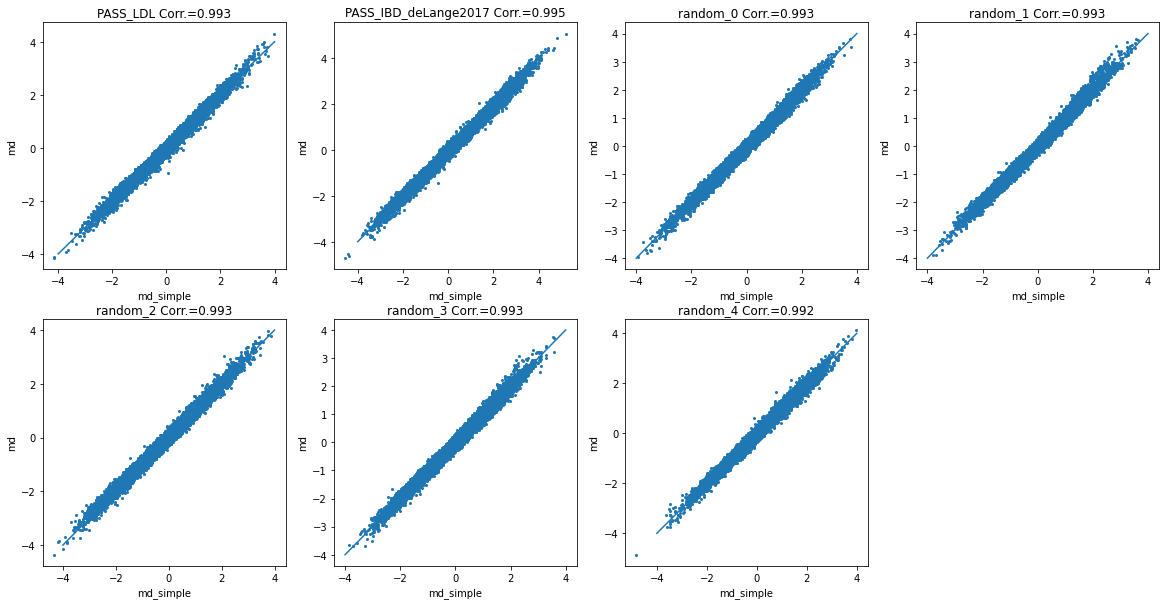

In [11]:
# Do the z-scores look similar to md_simple?
plt.figure(figsize=[20,10])
for i_trait,trait in enumerate(gene_set_dict.keys()):
    plt.subplot(2,4,i_trait+1)
    plt.scatter(dic_score['%s.md_simple'%trait], dic_score['%s.md'%trait], s=4)
    plt.plot([-4,4],[-4,4])
    plt.xlabel('md_simple')
    plt.ylabel('md')
    plt.title('%s Corr.=%0.3f'%(trait, np.corrcoef(dic_score['%s.md_simple'%(trait)],
                                                   dic_score['%s.md'%trait])[0,1]))
plt.show()

In [32]:
# Do the null p-values and alternative p-values look good? 
# Averaged over 5 random gene sets 
print('Random gene sets ')
for thres in [1e-1,1e-2,1e-3]:
    val_list = []
    for i_trait,trait in enumerate(gene_set_dict.keys()):
        if 'random' not in trait:
            pass
        val_list.append((dic_md_res[trait]['pval']<thres).mean())
    
    print('# proportion of p<%0.1e: \t %0.1e  CI=%0.1e'
          %(thres,np.mean(val_list), np.std(val_list)/np.sqrt(len(val_list))*1.96))

Random gene sets 
# proportion of p<1.0e-01: 	 1.1e-01  CI=1.3e-02
# proportion of p<1.0e-02: 	 1.6e-02  CI=7.9e-03
# proportion of p<1.0e-03: 	 2.7e-03  CI=2.3e-03


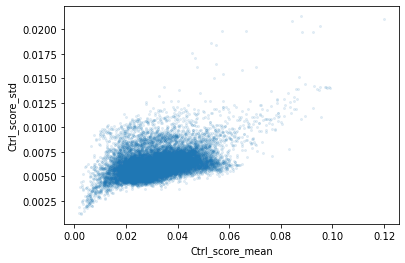

In [38]:
# How different are the control raw score between cells 
v_mean = df_res[[x for x in df_res.columns if 'ctrl_raw_score' in x]].mean(axis=1)
v_std = df_res[[x for x in df_res.columns if 'ctrl_raw_score' in x]].std(axis=1)

plt.figure()
plt.scatter(v_mean, v_std, s=4, alpha=0.1)
plt.xlabel('Ctrl_score_mean')
plt.ylabel('Ctrl_score_std')
plt.show()

### Run score_cell and compare version

In [6]:
n_ctrl = 500

md.compute_stats(score_dataset)
dic_score = dict()

for trait in gene_set_dict.keys():
    
    print(trait)
    gene_list = gene_set_dict[trait]
    
    # Method Old
    start_time = time.time()
    md_old.score_cell(score_dataset, gene_list, n_ctrl=n_ctrl, bc_opt='empi')
    dic_score['%s.md_old'%trait] = score_dataset.obs['trs_ez'].values.copy()
    print('# md_old %s time=%0.1fs'%(trait, time.time()-start_time))

    # Method simple 
    start_time = time.time()
    v_ep = md_simple.score_cell(score_dataset, gene_list=gene_list, num_ctrl = n_ctrl)['trait_ep']
    dic_score['%s.md_simple'%trait] = md_simple.pval2zsc(v_ep)
    print('# md_simple %s time=%0.1fs'%(trait, time.time()-start_time))
    
#     # Method new 
#     md.score_cell(score_dataset, gene_list, n_ctrl=n_ctrl, bc_opt='debug')
#     dic_score['%s.md'%trait] = score_dataset.obs['trs_ez'].values.copy()

KeyboardInterrupt: 

In [104]:
for trait in gene_set_dict.keys():
    
    gene_list = gene_set_dict[trait]
    # Method new 
    start_time = time.time()
    df_res = md.score_cell(score_dataset, gene_list, n_ctrl=500, 
                           return_ctrl_raw_score=True, 
                           return_ctrl_norm_score=True, verbose=False)
    dic_score['%s.md'%trait] = df_res['zscore'].values
    print('# %s time=%0.1fs'%(trait, time.time()-start_time))

# PASS_LDL time=78.4s
# random_0 time=78.7s


PASS_LDL


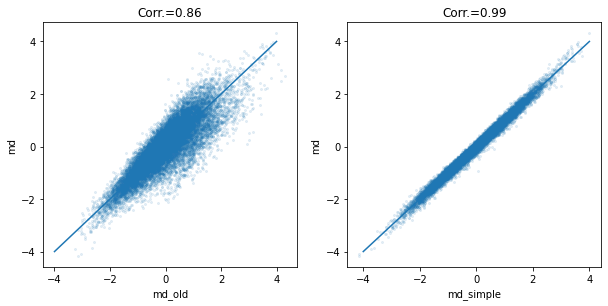

random_0


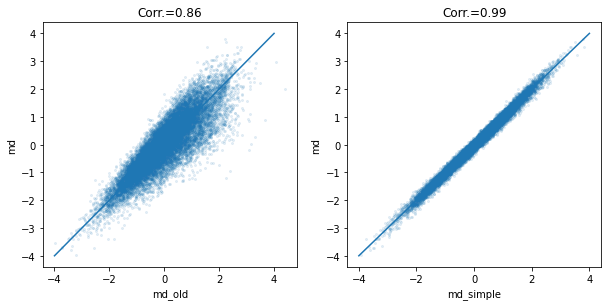

In [105]:
for trait in gene_set_dict.keys():
    
    print(trait)
    plt.figure(figsize=[10,4.5])
    for i,md_ref in enumerate(['md_old', 'md_simple']):
        plt.subplot(1,2,i+1)
        plt.scatter(dic_score['%s.%s'%(trait,md_ref)], dic_score['%s.md'%trait], s=4, alpha=0.1)
        plt.plot([-4,4],[-4,4])
        plt.xlabel(md_ref)
        plt.ylabel('md')
        plt.title('Corr.=%0.2f'%(np.corrcoef(dic_score['%s.%s'%(trait,md_ref)], dic_score['%s.md'%trait])[0,1]))
    plt.show()
    

In [103]:
df_res

,raw_score,norm_score,mc_pval,pval,zscore,ctrl_norm_score_0,ctrl_norm_score_1,ctrl_norm_score_2,ctrl_norm_score_3,ctrl_norm_score_4,...,ctrl_norm_score_10,ctrl_norm_score_11,ctrl_norm_score_12,ctrl_norm_score_13,ctrl_norm_score_14,ctrl_norm_score_15,ctrl_norm_score_16,ctrl_norm_score_17,ctrl_norm_score_18,ctrl_norm_score_19
index,,,,,,,,,,,,,,,,,,,,,
A10_B000497_B009023_S10.mm10-plus-0-0,0.037059,-0.553641,0.761905,0.690303,-0.496710,-0.348370,0.603241,-0.356661,0.634361,0.228139,...,-1.087591,-0.118612,-0.191709,-0.501743,-0.282574,-0.808034,-0.130844,2.943440,-1.078000,0.402286
A10_B000756_B007446_S10.mm10-plus-0-0,0.083978,2.882699,0.047619,0.002410,2.818824,-0.127709,-0.869373,0.367545,-1.179595,0.312090,...,2.318877,0.241545,0.878758,-0.609549,-1.656915,-0.469183,-1.281062,0.261792,0.046858,0.775314
A10_B000802_B009022_S10.mm10-plus-0-0,0.042043,-0.094116,0.523810,0.511691,-0.029310,-0.304657,-0.078081,-0.659241,0.810868,0.713193,...,0.849142,0.682733,1.902418,-0.037080,0.177450,-0.219734,-0.991971,-1.386626,-0.507955,-0.380512
A10_B000927_B007456_S10.mm10-plus-0-0,0.018472,-0.367550,0.666667,0.618786,-0.302294,0.037961,0.457365,-0.658586,-1.006762,-0.391183,...,0.611425,0.042647,-0.292302,-1.667673,-0.685013,1.771846,-0.117532,2.368555,-0.278355,-0.951012
A10_B001361_B007505_S10.mm10-plus-0-0,0.017918,-1.177598,0.857143,0.886278,-1.206968,1.187925,-0.953171,-1.584556,-0.476391,0.144509,...,-1.248010,0.843755,0.083472,-0.634933,-0.874933,-1.268318,1.355229,-1.030058,-0.029249,-0.186423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B10_B002417_B009885_S34.mm10-plus-6-0,0.062816,0.107486,0.380952,0.434661,0.164519,1.351224,-0.027304,1.638373,-0.049124,-0.387281,...,0.878049,-1.439068,0.468830,-0.594176,-0.230743,-1.182495,-0.148232,-1.029555,-0.978259,-0.537951
B10_B003682_B009883_S34.mm10-plus-6-0,0.033478,-1.245734,0.857143,0.901668,-1.291113,-1.088652,0.358130,-1.888297,-0.336787,0.764230,...,1.735049,-0.330698,-0.104017,-1.523581,1.496208,0.522594,-0.358034,0.221202,-1.604979,-0.316270
B10_D045405_B009854_S34.mm10-plus-6-0,0.021477,0.338298,0.333333,0.352439,0.378744,-0.618148,0.161559,-0.071239,0.619292,1.542521,...,0.498896,-0.231688,-0.511431,-1.385541,-0.791853,1.623298,-0.154786,0.419285,-0.924787,2.371197


In [ ]:
#### plt.figure()
# plt.scatter(score_dataset.var['mean'], np.log10(score_dataset.var['var'].values.clip(min=0.0001)), s=4)
plt.scatter(np.log10(score_dataset.var['mean']), 
            np.log10(score_dataset.var['var'].values.clip(min=1e-10)), s=4)
plt.scatter(np.log10(score_dataset.var['mean']), 
            np.log10(score_dataset.var['var_tech'].values.clip(min=1e-10)), s=4)
# plt.xlim([0,0.1])
plt.show()

In [31]:
score_dataset.var['mean'][score_dataset.var['mean']>0].min()

1.6745046e-08

In [78]:
{x:y for x,y in zip([1,1,2], [1,2,3])}

{1: 2, 2: 3}

In [49]:
adata = score_dataset
gene_weight = np.arange(len(gene_list))

In [50]:
# Gene-wise statistics
df_gene = pd.DataFrame(index=adata.var_names)
df_gene['gene'] = df_gene.index
df_gene['mean'] = adata.var['mean'].values
df_gene['var'] = adata.var['var'].values
df_gene['tvar'] = adata.var['var_tech'].values
df_gene['bvar'] = df_gene['var'].values - df_gene['tvar'].values
df_gene.drop_duplicates(subset='gene', inplace=True)

# Update gene_list  
gene_list = list(gene_list)
n_gene_old = len(gene_list)

df_trait_gene = pd.DataFrame(index=gene_list, columns=['gene', 'gene_weight'], data=0)
df_trait_gene['gene'] = df_trait_gene.index
df_trait_gene['gene_weight'] = 1 if gene_weight is None else np.array(gene_weight)
df_trait_gene.drop_duplicates(subset='gene', inplace=True)

gene_list = list(set(df_gene['gene'].values) & set(gene_list))
gene_list.sort()
df_trait_gene = df_trait_gene.loc[gene_list].copy()
gene_weight = df_trait_gene['gene_weight'].values.copy()

In [51]:
dic_ctrl_list_ref,dic_ctrl_weight_ref = md_old._select_ctrl_geneset(df_gene, gene_list, gene_weight,
                                                            'mean_match', None, 2, 200,
                                                            0, True)

# score_cell: ctrl0 geneset,  500 genes,      mean_exp=9.70e-02   
# score_cell: ctrl1 geneset,  500 genes,      mean_exp=9.75e-02   


In [52]:
dic_ctrl_list,dic_ctrl_weight = md._select_ctrl_geneset(df_gene, gene_list, gene_weight,
                                                        'mean', 2, 200, 0, True)

# score_cell: ctrl0 geneset,  500 genes,      mean_exp=9.65e-02   
# score_cell: ctrl1 geneset,  500 genes,      mean_exp=9.79e-02   
